# RUL and SOH Estimator

## Data Description:

    A set of four Li-ion batteries (# 45 - 48) were run through 3 different operational profiles (charge, discharge and impedance) at an ambient temperature of 4 deg C. 
    Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. 
    "Fixed load current level of 1A" was used and the discharge runs were stopped at 2V, 2.2V, 2.5V and 2.7V for batteries 45, 46, 47 and 48 respectively.
    Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz. The experiments were carried out until the capacity had reduced to 1.4Ahr (30% fade). 
    Note that there are several discharge runs where the capacity was very low. Reasons for this have not been fully analyzed.

### Files:
    B0047.mat	Data for Battery #47

## Data Structure:
    cycle-	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	data:	data structure containing the measurements
#### for charge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at charger (Amps)
		Voltage_charge:		Voltage measured at charger (Volts)
		Time:			Time vector for the cycle (secs)
#### for discharge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at load (Amps)
		Voltage_charge:		Voltage measured at load (Volts)
		Time:			Time vector for the cycle (secs)
		Capacity:		Battery capacity (Ahr) for discharge till 2.7V
#### for impedance the fields are:
		Sense_current:		Current in sense branch (Amps)
		Battery_current:	Current in battery branch (Amps)
		Current_ratio:		Ratio of the above currents
		Battery_impedance:	Battery impedance (Ohms) computed from raw data
		Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms)
		Re:			Estimated electrolyte resistance (Ohms)
		Rct:			Estimated charge transfer resistance (Ohms)
##### link: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

        DF - DataFrame
        DT - DataType
        MAE -Mean Absolute error 
        RMSE - Root Mean Square error

## Modules to be imported

In [1]:
import scipy.io
import pandas
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,Ridge
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt

sns.set()

### Getting .mat file

In [2]:
mat=scipy.io.loadmat('BatteryAgingARC_45_46_47_48/B0046.mat')["B0046"][0][0][0][0]

   The function loadmat loads all variables stored in the MAT-file into a simple Python data structure, using only Python’s dict and list objects. Numeric and cell arrays are converted to row-ordered nested lists. Arrays are squeezed to eliminate arrays with only one element. The resulting data structure is composed of simple types that are compatible with the JSON format.

In [3]:
mat.shape #Getting Shape to DF

(184,)

In [4]:
def build(mess):
    discharge, charge, impedance = {}, {}, {}
    # data are in nested list.
    # To access the individual data in nested list using multiple indexing. 
    # And store into a single Dictionary set.

    for i, element in enumerate(mess):

        step = element[0][0]

        if step == 'discharge':
            discharge[str(i)] = {}
            discharge[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000) # converting seconds to millisecond
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)  # time values to data_time object   
            discharge[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S") #appending date_time object into string format
            data = element[3]
            discharge[str(i)]["time_sec"] = data[0][0][5][0].tolist()
            discharge[str(i)]["time_taken"] = discharge[str(i)]["time_sec"][len(discharge[str(i)]["time_sec"])-1]-discharge[str(i)]["time_sec"][0]
            #Time Taken :
            #    time_taken = End_time - start_time
            # Total Time Taken for Discharge
            discharge[str(i)]["temp_battery"] = data[0][0][2][0].tolist()
            discharge[str(i)]["voltage_load"] = data[0][0][4][0].tolist()
            discharge[str(i)]["voltage_battery"] = data[0][0][0][0].tolist()
            discharge[str(i)]["current_battery"] = data[0][0][1][0].tolist()
            discharge[str(i)]["current_load"] = data[0][0][3][0].tolist()
            discharge[str(i)]["capacity"] = data[0][0][6][0][0]
            discharge[str(i)]["deltaV"] = abs(4.2-discharge[str(i)]["voltage_battery"][1])
            # DeltaV :
            #      deltaV = (Max_Threshold_voltage - Initial_voltage_value)
            #      Voltage Slope or change in voltage 
            
    

        if step == 'charge':
            charge[str(i)] = {}
            charge[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)# converting seconds to millisecond
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)  # time values to data_time object
            charge[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S") #appending date_time object into string format
            data = element[3]
            charge[str(i)]["voltage_battery"] = data[0][0][0][0].tolist()
            charge[str(i)]["current_battery"] = data[0][0][1][0].tolist()
            charge[str(i)]["temp_battery"] = data[0][0][2][0].tolist()
            charge[str(i)]["current_load"] = data[0][0][3][0].tolist()
            charge[str(i)]["voltage_load"] = data[0][0][4][0].tolist()
            charge[str(i)]["time_sec"] = (data[0][0][5][0]).tolist()
            charge[str(i)]["time_taken"] = charge[str(i)]["time_sec"][len(charge[str(i)]["time_sec"])-1]-charge[str(i)]["time_sec"][0]
            #Time Taken :
            #    time_taken = End_time - start_time
            # Total Time Taken for charge

        if step == 'impedance':
            impedance[str(i)] = {}
            impedance[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)# converting seconds to millisecond
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)  # time values to data_time object    

            impedance[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")#appending date_time object into string format

            data = element[3]

            impedance[str(i)]["sense_current"] = {}
            impedance[str(i)]["battery_current"] = {}
            impedance[str(i)]["current_ratio"] = {}
            impedance[str(i)]["battery_impedance"] = {}
            impedance[str(i)]["rectified_impedance"] = {}
            # real value            imaginary value
            # x            +         (j)      y

            impedance[str(i)]["sense_current"]["real"] = np.real(data[0][0][0][0]).tolist() #real value
            impedance[str(i)]["sense_current"]["imag"] = np.imag(data[0][0][0][0]).tolist() #imaginary value

            impedance[str(i)]["battery_current"]["real"] = np.real(data[0][0][1][0]).tolist() #real value
            impedance[str(i)]["battery_current"]["imag"] = np.imag(data[0][0][1][0]).tolist() #imaginary value

            impedance[str(i)]["current_ratio"]["real"] = np.real(data[0][0][2][0]).tolist() # real value
            impedance[str(i)]["current_ratio"]["imag"] = np.imag(data[0][0][2][0]).tolist() # imaginary value

            impedance[str(i)]["battery_impedance"]["real"] = np.real(data[0][0][3]).tolist()#real value
            impedance[str(i)]["battery_impedance"]["imag"] = np.imag(data[0][0][3]).tolist()#imaginary value

            impedance[str(i)]["rectified_impedance"]["real"] = np.real(data[0][0][4]).tolist()#real value
            impedance[str(i)]["rectified_impedance"]["imag"] = np.imag(data[0][0][4]).tolist()#imaginary value

            impedance[str(i)]["re"] = float(data[0][0][5][0][0])
            impedance[str(i)]["rct"] = float(data[0][0][6][0][0])
            
    return discharge, charge, impedance

From Data description data structured consists of three types of operation - Charge,Discharge and Impedance with specific datas in each types.

Build Function:
    Separates each types with their specific data and return into three different dictionary values.


In [5]:
discharge, charge, impedance=build(mat) #calling built function and getting dictionary sets

In [6]:
discharge = pd.DataFrame(discharge).T
charge = pd.DataFrame(charge).T
impedance = pd.DataFrame(impedance).T

convert dictionary sets into DF and done Transpose to change rows into columns and vice versa

In [7]:
index=[i for i in range(1,73,1)] # adding cycle column and setting cycle column as index
discharge['cycle']=index
discharge.set_index(['cycle'])
charge['cycle']=index
charge.set_index(['cycle'])
print()

### Exploding Charge DF

In [8]:
list_cols = {'voltage_load','temp_battery','time_sec','voltage_battery','current_load','current_battery'} #list of columns to explode
other_cols = list(set(charge.columns) - set(list_cols))
exploded = [charge[col].explode() for col in list_cols]
df1 = pd.DataFrame(dict(zip(list_cols, exploded)))
df1 = charge[other_cols].merge(df1, how="right", left_index=True, right_index=True)

In [9]:
df1.drop(['date_time'],axis=1,inplace=True) # Dropping date_time because it is string object which can't be converted into float object
df1=df1.astype(float) #Changing all DT into float
df1.sort_values('cycle') # sorting DF with respect to cycle

,amb_temp,cycle,time_taken,voltage_battery,time_sec,current_load,temp_battery,voltage_load,current_battery
2,4.0,1.0,10803.313,4.197302,10729.406,0.061,5.779463,4.241,0.061108
2,4.0,1.0,10803.313,4.199795,7097.531,0.160,5.940534,4.295,0.160727
2,4.0,1.0,10803.313,4.199912,7090.781,0.160,5.925144,4.295,0.159277
2,4.0,1.0,10803.313,4.199768,7084.047,0.160,5.908140,4.295,0.161819
2,4.0,1.0,10803.313,4.199946,7077.297,0.160,5.896631,4.295,0.160545
...,...,...,...,...,...,...,...,...,...
182,4.0,72.0,10808.891,4.198750,3567.266,0.404,6.509353,4.435,0.406212
182,4.0,72.0,10808.891,4.198768,3558.532,0.404,6.508994,4.435,0.408282
182,4.0,72.0,10808.891,4.198474,3549.844,0.404,6.501819,4.435,0.406488
182,4.0,72.0,10808.891,4.199582,3610.954,0.403,6.568802,4.435,0.406880


Getting the DF for Voltage in battery higher than 4.2 Threshold

In [10]:
df1=df1[df1['voltage_battery']>4.2].groupby('cycle')

Time taken for battery to reach maximum voltage Threshold while charging.

In [11]:
Charging_max_Threshold_voltage_time=df1.min()['time_sec']
Charging_max_Threshold_voltage_temp=df1.min()['temp_battery']

### Exploding Discharge DF

In [12]:
list_cols = {'voltage_load','temp_battery','time_sec','voltage_battery','current_load','current_battery'}
other_cols = list(set(discharge.columns) - set(list_cols))
exploded = [discharge[col].explode() for col in list_cols]
df2 = pd.DataFrame(dict(zip(list_cols, exploded)))
df2 = discharge[other_cols].merge(df2, how="right", left_index=True, right_index=True)
df2.drop(['date_time'],axis=1,inplace=True)# Dropping date_time because it is string object which can't be converted into float object
df2=df2.astype(float)#Changing DT into float

Getting the DF for minimum thershold Voltage(2.5) in battery.

In [13]:
df2=df2[df2['voltage_battery']<2.2]
df2=df2.sort_values('cycle')
df2 #sorting with respect to cycle

,amb_temp,cycle,time_taken,capacity,deltaV,voltage_battery,time_sec,current_load,temp_battery,voltage_load,current_battery
0,4.0,1.0,6436.141,1.728239,0.037819,2.179300,6436.141,0.9990,13.105428,1.723,-1.003137
4,4.0,2.0,5650.265,1.516149,0.037661,2.174474,5650.265,0.9988,12.938221,1.724,-1.004201
6,4.0,3.0,5590.907,1.503121,0.019450,2.195667,5590.907,0.9986,12.400467,1.748,-1.006270
8,4.0,4.0,5543.610,1.485866,0.018388,2.179628,5543.610,0.9986,12.683911,1.731,-1.004997
10,4.0,5.0,5499.046,1.469456,0.019765,2.195258,5499.046,0.9988,13.065400,1.745,-1.006559
...,...,...,...,...,...,...,...,...,...,...,...
172,4.0,68.0,4663.907,1.205045,0.056289,2.183932,4663.907,0.9988,13.853422,1.721,-1.004951
174,4.0,69.0,4581.328,1.191199,0.026811,2.196285,4581.328,0.9988,14.172939,1.736,-1.004888
176,4.0,70.0,4553.031,1.174638,0.026733,2.152654,4553.031,0.9988,14.314751,1.694,-1.004308
178,4.0,71.0,4486.500,1.155543,0.026697,2.196331,4486.500,0.9988,14.868149,1.737,-1.005997


In [14]:
Discharge_min_Threshold_voltage_time = df2['time_sec']
Discharge_min_Threshold_voltage_temp = df2['temp_battery']

### Dataset Selection

    Varaible/Features:
    
        cycle                                -> Cycle count
        max_temp_char                        -> Maximum Temperature while charging
        max_temp_dis                         -> Maximum Temperature while discharging
        cap                                  -> Capacity of battery
        time_discharge                       -> Time taken to discharge
        time_charge                          -> Time taken to charge
        dis_vol                              -> Discharge Voltage
        dis_cur                              -> Discharge Current
        Discharge_min_Threshold_voltage_time -> Time taken to reach minimum threshold voltage while discharge
        Charging_max_Threshold_voltage_time  -> Time taken to reach maximum threshold voltage while charge
        Discharge_min_Threshold_voltage_temp -> Temperature at which minimum threshold voltage reach while discharge
        Charging_max_Threshold_voltage_temp  -> Temperature at which maximum threshold voltage reach while charge
        SOH                                  -> SOH = (capacity/nominal capacity)
        RUL                                  -> RUL = n-i+1
                                    n -> number of cycle
                                    i -> i(th) cycle 

In [15]:
cycle,max_temp_char,max_temp_dis,cap,time_discharge,time_charge,dis_vol,dis_cur=[],[],[],[],[],[],[],[]
for i in range(72):
    cycle.append(discharge['cycle'][i])
    max_temp_char.append(max(charge['temp_battery'][i]))
    max_temp_dis.append(max(discharge['temp_battery'][i]))
    cap.append(discharge['capacity'][i])
    time_discharge.append(discharge['time_taken'][i])
    time_charge.append(charge['time_taken'][i])
    dis_vol.append(2.5)
    dis_cur.append(1)

In [16]:
dic={"cycle":cycle, 'max_distemp':max_temp_dis, 'max_chtemp':max_temp_char,  'capacity':cap,'dis_time':time_discharge,'chr_time':time_charge,'Discharge_voltage':dis_vol,'Discharge_current':dis_cur}

#### Dictionary into DF

In [17]:
soh_df = pd.DataFrame(dic) 

In [18]:
soh_df=soh_df[soh_df['capacity']!=0] # filtering data with capacity value other than 0

Setting index

In [19]:
index=np.arange(1,70)
soh_df.set_index(index)

,cycle,max_distemp,max_chtemp,capacity,dis_time,chr_time,Discharge_voltage,Discharge_current
1,1,13.880081,9.325138,1.728239,6436.141,10803.313,2.5,1
2,2,12.941526,12.346120,1.516149,5650.265,10802.078,2.5,1
3,3,13.359691,11.598067,1.503121,5590.907,10807.688,2.5,1
4,4,12.683911,12.092569,1.485866,5543.610,10805.687,2.5,1
5,5,13.065400,12.490739,1.469456,5499.046,10804.078,2.5,1
...,...,...,...,...,...,...,...,...
65,68,14.454392,13.574847,1.205045,4663.907,10807.969,2.5,1
66,69,14.172939,13.649784,1.191199,4581.328,10809.594,2.5,1
67,70,14.797844,13.486367,1.174638,4553.031,10804.109,2.5,1
68,71,14.868149,14.316772,1.155543,4486.500,10810.344,2.5,1


   Adding features from both discharging and charging exploding data 

In [20]:
soh_df['Discharge_min_Threshold_voltage_time'] = Discharge_min_Threshold_voltage_time.tolist()
soh_df['Charging_max_Threshold_voltage_time'] = Charging_max_Threshold_voltage_time[:69].tolist()
soh_df['Discharge_min_Threshold_voltage_temp'] = Discharge_min_Threshold_voltage_temp.tolist()
soh_df['Charging_max_Threshold_voltage_temp'] = Charging_max_Threshold_voltage_temp[:69].tolist()
soh_df['SOH']=soh_df['capacity']/soh_df['capacity'].max()
soh_df['RUL']=72-soh_df['cycle']+1

columns for dataset

In [21]:
soh_df.columns

Index(['cycle', 'max_distemp', 'max_chtemp', 'capacity', 'dis_time',
       'chr_time', 'Discharge_voltage', 'Discharge_current',
       'Discharge_min_Threshold_voltage_time',
       'Charging_max_Threshold_voltage_time',
       'Discharge_min_Threshold_voltage_temp',
       'Charging_max_Threshold_voltage_temp', 'SOH', 'RUL'],
      dtype='object')

Saving dataset into csv file

In [22]:
soh_df

,cycle,max_distemp,max_chtemp,capacity,dis_time,chr_time,Discharge_voltage,Discharge_current,Discharge_min_Threshold_voltage_time,Charging_max_Threshold_voltage_time,Discharge_min_Threshold_voltage_temp,Charging_max_Threshold_voltage_temp,SOH,RUL
0,1,13.880081,9.325138,1.728239,6436.141,10803.313,2.5,1,6436.141,1427.625,13.105428,4.862409,1.000000,72
1,2,12.941526,12.346120,1.516149,5650.265,10802.078,2.5,1,5650.265,1351.484,12.938221,4.626419,0.877279,71
2,3,13.359691,11.598067,1.503121,5590.907,10807.688,2.5,1,5590.907,1304.875,12.400467,4.739180,0.869741,70
3,4,12.683911,12.092569,1.485866,5543.610,10805.687,2.5,1,5543.610,1220.953,12.683911,4.633242,0.859757,69
4,5,13.065400,12.490739,1.469456,5499.046,10804.078,2.5,1,5499.046,1202.719,13.065400,4.274888,0.850262,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,68,14.454392,13.574847,1.205045,4663.907,10807.969,2.5,1,4663.907,548.765,13.853422,5.203391,0.697268,5
68,69,14.172939,13.649784,1.191199,4581.328,10809.594,2.5,1,4581.328,95.172,14.172939,5.110313,0.689256,4
69,70,14.797844,13.486367,1.174638,4553.031,10804.109,2.5,1,4553.031,478.156,14.314751,5.201257,0.679673,3
70,71,14.868149,14.316772,1.155543,4486.500,10810.344,2.5,1,4486.500,677.735,14.868149,5.131967,0.668625,2


In [23]:
soh_df.to_csv('Dataset.csv')

# State of Health Prediction

### Feature selection for SOH

Features normally considered for SOH\
    * Voltage\
    * Time\
    * Current\
    * Temperature
    
current-constant (doesn't affect much)\
Temperature (Doesn't affect much because of Ambient/room temperature 4 deg celsius)

    Dropping columns:
    
        cycle -> which is directly correlated with SOH
        capacity -> which is as same as SOH
        max_distemp, max_chtemp, Charging_max_Threshold_voltage_temp, Discharge_min_Threshold_voltage_temp-> Temperature factor is not affecting SOH mostly because of Ambient/room temperature 4 deg celsius it can't cause battery to heat much.
        if Ambient is high, temperature factor will affect the SOH prediction
        dis_time, chr_time -> we drop these features because charge, discharge voltage values doesn't give exact explaination of charging and discharging than Charging_max_Threshold_voltage and Discharge_min_Threshold_voltage.
        
        
    Features selected:
    
        Discharge_min_Threshold_voltage_time
        Charging_max_Threshold_voltage_time
        Charging_max_Threshold_voltage_time(Sec) and Discharge_min_Threshold_voltage_time(Sec) both feature gives exact time taken for voltage to attain 4.2 max threshold while charging and gives exact time taken for voltage to attain 2.5 voltage drop threshold while discharging respectively which gives more detailed estimation for capacity.


Discharge_min_Threshold_voltage_time,Charging_max_Threshold_voltage_time are Time values with respect to voltage 
In these we considered both Voltage and Time for charging and discharging.

### Model selection for SOH

        Model                r2_score           Mean Absolute error(MAE)       Root mean Square error(RMSE)
        
        
     
     LinearRegression    0.99756192078892       0.0026904860747766165          0.0035585476728445882
     
     SVR                 0.9906417766713533     0.005747891069886788           0.006971810678756418
     
     Ridge               0.9693625454576208     0.010266501242172012           0.012614650502126604
     
     LinearRegression    0.9980478953255226     0.00239270731079238            0.0031842006989559165
     (Polynomial Features
     deg -2)
     
From above table Linear regression with polynomial features is good model because of low MAE and RMSE

### Linear Regression - Polynomial Features

Feature scaling

In [24]:
x=soh_df.drop(['capacity','dis_time','chr_time','cycle','max_chtemp','max_distemp','SOH','Discharge_voltage','Discharge_current',"RUL",'Discharge_min_Threshold_voltage_temp','Charging_max_Threshold_voltage_temp'],axis=1)
print(x.columns)
y=soh_df['SOH']
minmax=MinMaxScaler()
x=minmax.fit_transform(x)

Index(['Discharge_min_Threshold_voltage_time', 'Charging_max_Threshold_voltage_time'], dtype='object')


Train Test Data split

In [25]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15,random_state=32)

Getting polynomial Features for X

In [26]:
poly_reg = PolynomialFeatures()
x_poly = poly_reg.fit_transform(x_train)

LinearRegression Model object

In [27]:
lin_reg = LinearRegression()

Fitting model

In [28]:
lin_reg.fit(x_poly, y_train)

LinearRegression()

Predicting SOH for train,test and Total value

In [29]:
y_pred = lin_reg.predict(poly_reg.transform(x))
y_pred_train = lin_reg.predict(poly_reg.transform(x_train))
y_pred_test = lin_reg.predict(poly_reg.transform(x_test))

Calculating r2_score,MAE and RMSE

In [30]:
print('r2 score train',r2_score(y_train,y_pred_train))
print('r2 score test',r2_score(y_test,y_pred_test))
print('r2 score ',r2_score(y,y_pred))
print('Root mean square error',sqrt(mean_squared_error(y,y_pred)))
print('mean absolute error',mean_absolute_error(y,y_pred))

r2 score train 0.9984260175142214
r2 score test 0.9948297998660734
r2 score  0.9980478953255226
Root mean square error 0.0031842006989559165
mean absolute error 0.00239270731079238


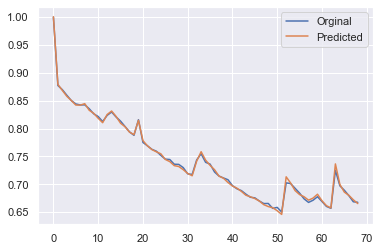

In [31]:
plt.plot(list(y))
plt.plot(list(y_pred))
plt.legend(labels=['Orginal','Predicted'])

### Hyperparameter tuning

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold,GridSearchCV
from sklearn.pipeline import Pipeline
models = dict()
for d in range(1,11):
# define the pipeline
    trans = PolynomialFeatures(degree=d)
    model = LinearRegression()
    models[str(d)] = Pipeline(steps=[('t', trans), ('m', model)])
models

{'1': Pipeline(steps=[('t', PolynomialFeatures(degree=1)), ('m', LinearRegression())]),
 '2': Pipeline(steps=[('t', PolynomialFeatures()), ('m', LinearRegression())]),
 '3': Pipeline(steps=[('t', PolynomialFeatures(degree=3)), ('m', LinearRegression())]),
 '4': Pipeline(steps=[('t', PolynomialFeatures(degree=4)), ('m', LinearRegression())]),
 '5': Pipeline(steps=[('t', PolynomialFeatures(degree=5)), ('m', LinearRegression())]),
 '6': Pipeline(steps=[('t', PolynomialFeatures(degree=6)), ('m', LinearRegression())]),
 '7': Pipeline(steps=[('t', PolynomialFeatures(degree=7)), ('m', LinearRegression())]),
 '8': Pipeline(steps=[('t', PolynomialFeatures(degree=8)), ('m', LinearRegression())]),
 '9': Pipeline(steps=[('t', PolynomialFeatures(degree=9)), ('m', LinearRegression())]),
 '10': Pipeline(steps=[('t', PolynomialFeatures(degree=10)),
                 ('m', LinearRegression())])}

Setting pipeline for degrees in polynomial feature

In [33]:
def evaluate_model(model, x, y):   
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    parameters = {}
    search = GridSearchCV(model, parameters, n_jobs=-1, cv=cv)
    result = search.fit(x, y)
    return result


# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, x, y)
    print("Degree:",name,', Score :',scores.best_score_,', n_splits:',scores.n_splits_)

Degree: 1 , Score : 0.9943689019169326 , n_splits: 30
Degree: 2 , Score : 0.9953258969094947 , n_splits: 30
Degree: 3 , Score : 0.9689451239892827 , n_splits: 30
Degree: 4 , Score : -0.5189410485577558 , n_splits: 30
Degree: 5 , Score : -75.82368110028075 , n_splits: 30
Degree: 6 , Score : -17913.28879019703 , n_splits: 30
Degree: 7 , Score : -5179207.274815919 , n_splits: 30
Degree: 8 , Score : -117186083.77385327 , n_splits: 30
Degree: 9 , Score : -66225012726.226776 , n_splits: 30
Degree: 10 , Score : -2325636674684694.5 , n_splits: 30


From above shell we can say degree - 2 is best 

# Remaining Cycle Prediction

### Feature selection for RUC


Features normally considered for RUC\
    * Voltage\
    * Time\
    * Current\
    * Temperature\
    * Capacity
    
current-constant (doesn't affect much)\
Temperature (Doesn't affect much because of Ambient/room temperature 4 deg celsius)

    Dropping columns:
    
        cycle -> which is directly correlated with RUL
        max_distemp, max_chtemp, Charging_max_Threshold_voltage_temp, Discharge_min_Threshold_voltage_temp-> Temperature factor is not affecting SOH mostly because of Ambient/room temperature 4 deg celsius it can't cause battery to heat much.
        if Ambient is high, temperature factor will affect the SOH prediction
        dis_time, chr_time -> we drop these features because charge, discharge voltage values doesn't give exact explaination of charging and discharging than Charging_max_Threshold_voltage and Discharge_min_Threshold_voltage.
        
        
        
    Features selected:
        
        capacity is required but we are using SOH because which is as same as capacity.
        so SOH Feature is more than enough to predict the model.
        Discharge_min_Threshold_voltage_time
        Charging_max_Threshold_voltage_time
        Charging_max_Threshold_voltage_time(Sec) and Discharge_min_Threshold_voltage_time(Sec) both feature gives exact time taken for voltage to attain 4.2 max threshold while charging and gives exact time taken for voltage to attain 2.5 voltage drop threshold while discharging respectively which gives more detailed estimation for capacity.


Discharge_min_Threshold_voltage_time,Charging_max_Threshold_voltage_time are Time values with respect to voltage 
In these we considered both Voltage and Time for charging and discharging.

### Model selection for SOH

        Model                r2_score           Mean Absolute error(MAE)       Root mean Square error(RMSE)
        
        
     
     LinearRegression    0.8509796174988952     6.196367128165051              8.000302077948735
     
     SVR                 0.17236536161325533    16.197060498562497             18.853972874667864
     
     SVR(linear)         0.7474845507784984     6.854289933884003              10.414238649540584
     
     SVR(poly)           0.591608072321542      10.276147454218194             13.244089996751326
     
     SVR(rbf)            0.898527711786203      4.220919979033104              6.601722660229034
     
     Ridge               0.7860445780525692     7.009061952134607              9.586171556006965
     
     Lasso               0.7860070259108836     7.0093710681045405             9.587012772077065
     
     ElasticNet          0.785996657821251      7.009566070393674              9.587245017561282
     
     LinearRegression    0.8988387955474056     4.442995733473573              6.591595436489932
     (Polynomial Features
     deg -2)
     
     
    
    1)From above table SVR(rbf) and polynomial regression had higher r2_score have more over same r2_score.
    2)While Predicting Dynamic data SVR gives better prediction value then polynomial regression. 

### SVR

Feature scaling

In [34]:
x=soh_df.drop(['capacity','dis_time','chr_time','cycle','max_chtemp','max_distemp','Discharge_voltage','Discharge_current',"RUL",'Discharge_min_Threshold_voltage_temp','Charging_max_Threshold_voltage_temp'],axis=1)
print(x.columns)
y=soh_df['RUL']
minmax=MinMaxScaler()
x=minmax.fit_transform(x)

Index(['Discharge_min_Threshold_voltage_time',
       'Charging_max_Threshold_voltage_time', 'SOH'],
      dtype='object')


Train Test Data split

In [35]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15,random_state=32)

Hyper tuning

In [36]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# Parameters for tuning
parameters = [{'kernel': ['rbf','linear','poly'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],'C': [1, 10, 100, 1000, 10000]}]
print("Tuning hyper-parameters")
svr = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = cv)
svr.fit(x, y)
svr.best_params_

Tuning hyper-parameters


{'C': 10000, 'gamma': 0.5, 'kernel': 'rbf'}

LinearRegression Model object

In [37]:
svr = SVR(kernel='rbf',epsilon=0.01,C=10000,gamma=0.5)

Fitting model

In [38]:
svr.fit(x_train, y_train)

SVR(C=10000, epsilon=0.01, gamma=0.5)

Predicting SOH for train,test and Total value

In [40]:
y_pred = svr.predict(x)
y_pred_train = svr.predict(x_train)
y_pred_test = svr.predict(x_test)

Calculating r2_score,MAE and RMSE

In [41]:
print('r2 score train',r2_score(y_train,y_pred_train))
print('r2 score test',r2_score(y_test,y_pred_test))
print('r2 score ',r2_score(y,y_pred))
print('Root mean square error',sqrt(mean_squared_error(y,y_pred)))
print('mean absolute error',mean_absolute_error(y,y_pred))

r2 score train 0.9018625861440464
r2 score test 0.8732925136151853
r2 score  0.898527711786203
Root mean square error 6.601722660229034
mean absolute error 4.220919979033104


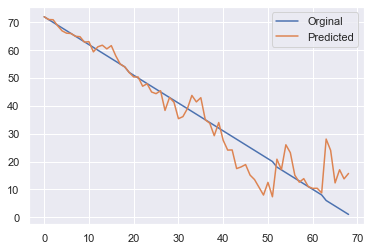

In [42]:
plt.plot(list(y))
plt.plot(list(y_pred))
plt.legend(labels=['Orginal','Predicted'])

# END 